### Walmart Sales Forecasting - Using ARIMA

In [2]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

#### Data Preprocessing

In [3]:
# importing the dataset

df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst = True)
df = df.drop_duplicates(subset='Date', keep='first')
df.set_index('Date',inplace= True)
df = df.resample('W-FRI').sum()
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


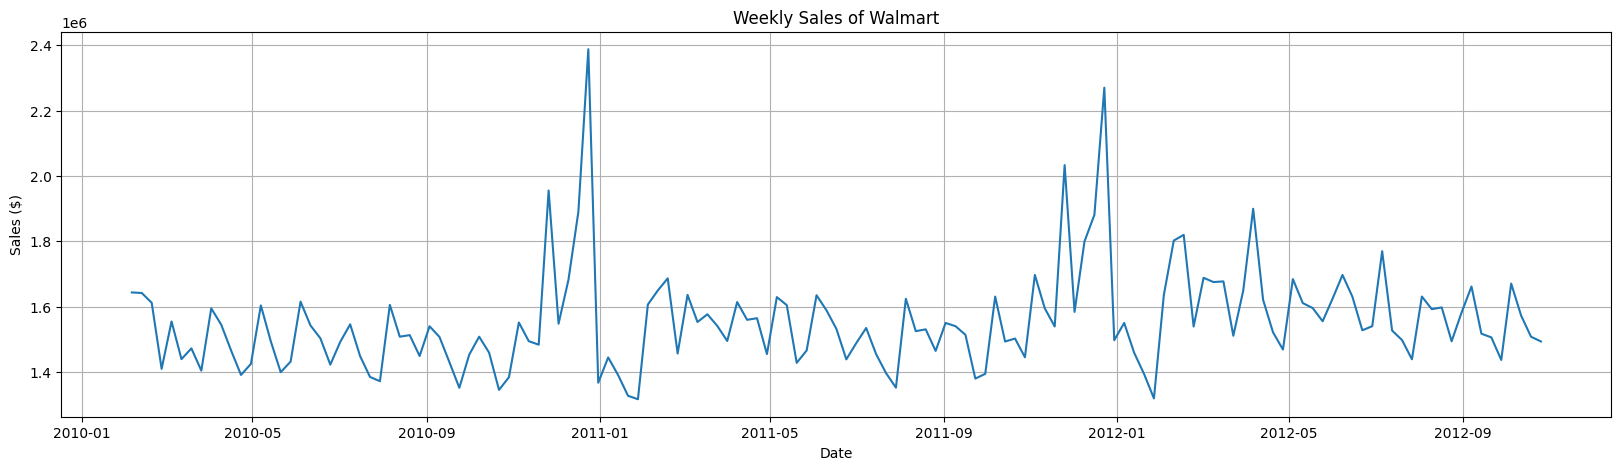

In [6]:
# plotting Weekly sales

plt.figure(figsize=(20,5))
plt.plot(df['Weekly_Sales'], label = 'Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.title('Weekly Sales of Walmart')
plt.grid()
plt.show()

#### Seasonality test

<Figure size 2000x500 with 0 Axes>

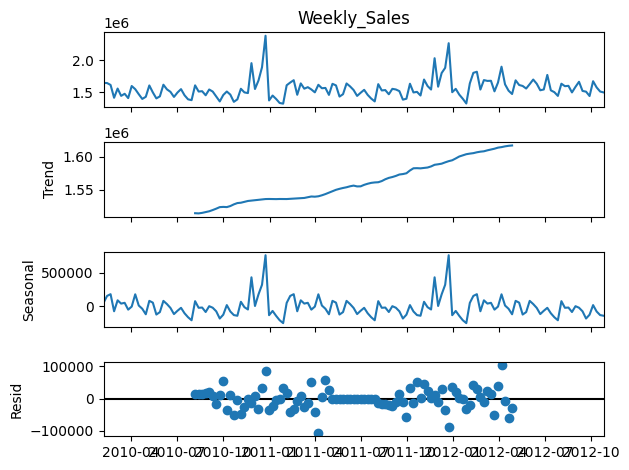

In [7]:
# seasonality check

from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(20,5))
snl = seasonal_decompose(df['Weekly_Sales'])
snl.plot()
plt.show()

#### Stationarity test

In [8]:
# stationarity check

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print('Dickey Fuller test results')
    adf = adfuller(timeseries,autolag ='AIC')
    adf_output = pd.Series(adf[0:4],index = ['Test Statistics','p-value','No of lags','No of Observations'])
    for key,value in adf[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print(adf_output)

In [9]:
adf_test(df['Weekly_Sales'])

Dickey Fuller test results
Test Statistics          -5.102186
p-value                   0.000014
No of lags                4.000000
No of Observations      138.000000
Critical Value (1%)      -3.478648
Critical Value (5%)      -2.882722
Critical Value (10%)     -2.578065
dtype: float64


p < 0.05 . Therefore, the time series is stationary.

In [10]:
# if p > 0.05, differencing is required. In that case use the following code for differencing.

#df['Sales_Diff'] = df['Weekly_Sales'].diff().dropna()
#result_diff = adfuller(df['Sales_Diff'].dropna())
#print(f"ADF after differencing: {result_diff[1]}")

In [11]:
# Calculate min and max
min_val = df['Weekly_Sales'].min()
max_val = df['Weekly_Sales'].max()

# Apply Min-Max scaling
df['Weekly_Sales'] = (df['Weekly_Sales'] - min_val) / (max_val - min_val)
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,0.305113,0,42.31,2.572,211.096358,8.106
2010-02-12,1,0.303495,1,38.51,2.548,211.242170,8.106
2010-02-19,1,0.275495,0,39.93,2.514,211.289143,8.106
2010-02-26,1,0.086670,0,46.63,2.561,211.319643,8.106
2010-03-05,1,0.222125,0,46.50,2.625,211.350143,8.106


In [12]:
# splitting training and test data

train_size = int(len(df)*0.8)
test_size = len(df) - train_size

df_train = df[:train_size]
df_test = df[train_size:]

#### Identifying SARIMA Orders [p,d,q][P,D,Q,s] using ACF and PACF plots

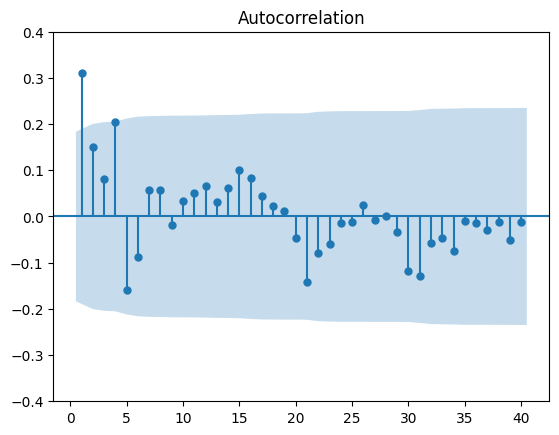

In [15]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

# acf plot

plot_acf(df_train['Weekly_Sales'],lags=40,zero=False)
plt.ylim(-0.4,0.4)
plt.show()

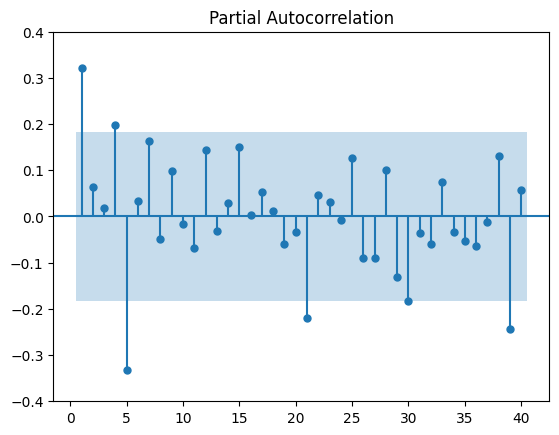

In [18]:
plot_pacf(df_train['Weekly_Sales'],lags=40,zero=False, method  = 'ols')
plt.ylim(-0.4,0.4)
plt.show()

Best model : SARIMA(1,0,1)(1,0,1,52)

#### Training SARIMA model

In [52]:
model = SARIMAX(
    df_train['Weekly_Sales'],
    order = (1,0,1),
    seasonal_order= (1,0,1,52),
    enforce_stationarity= False
)

results = model.fit(disp=False)
print(results.summary())

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood                  84.097
Date:                            Sat, 31 May 2025   AIC                           -158.193
Time:                                    22:20:27   BIC                           -147.721
Sample:                                02-05-2010   HQIC                          -154.097
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0106      0.019     53.140      0.000       0.973       1.048
ma.L1         -0.8347      0.136   

#### Model Validation

In [40]:
# Forecast on test data
forecast_test = results.get_forecast(steps=test_size)
forecast_mean_test = forecast_test.predicted_mean
conf_int_test = forecast_test.conf_int()


In [41]:
# Calculate metrics

from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(df_test['Weekly_Sales'], forecast_mean_test)
rmse = mean_squared_error(df_test['Weekly_Sales'], forecast_mean_test, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.10
RMSE: 0.11


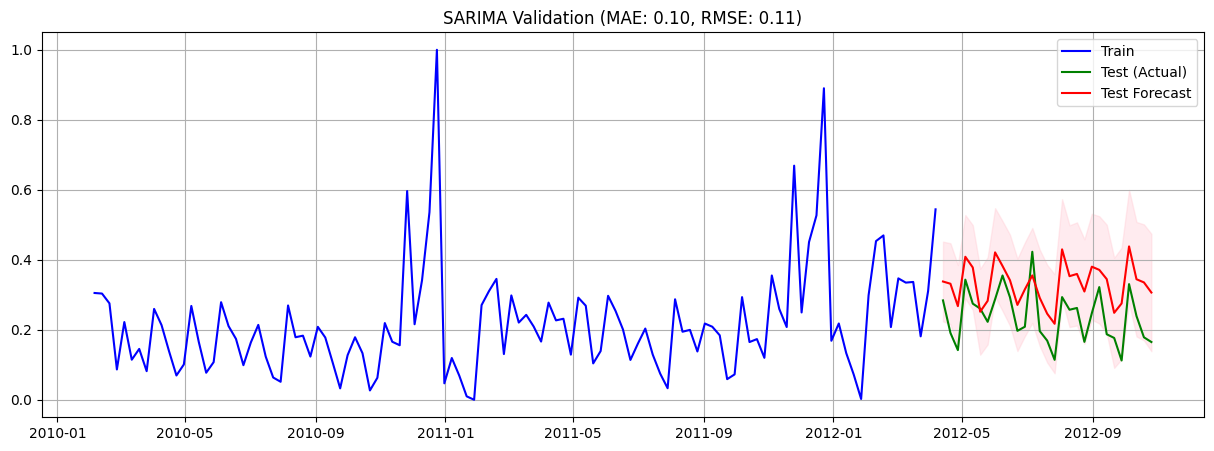

In [42]:
# Plot validation
plt.figure(figsize=(15, 5))
plt.plot(df_train.index, df_train['Weekly_Sales'], label='Train', color='blue')
plt.plot(df_test.index, df_test['Weekly_Sales'], label='Test (Actual)', color='green')
plt.plot(forecast_mean_test.index, forecast_mean_test, label='Test Forecast', color='red')
plt.fill_between(conf_int_test.index, conf_int_test.iloc[:, 0], conf_int_test.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f"SARIMA Validation (MAE: {mae:.2f}, RMSE: {rmse:.2f})")
plt.legend()
plt.grid()
plt.show()

#### Forecast

In [47]:
model = SARIMAX(
    df['Weekly_Sales'],
    order = (1,0,1),
    seasonal_order= (1,0,1,52),
    enforce_stationarity= False
)

results = model.fit(disp=False)
print(results.summary())

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood                 128.013
Date:                            Sat, 31 May 2025   AIC                           -246.026
Time:                                    22:18:00   BIC                           -233.583
Sample:                                02-05-2010   HQIC                          -241.011
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9921      0.013     75.215      0.000       0.966       1.018
ma.L1         -0.8775      0.082   

In [48]:
# forecasting next 12 weeks

forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
fitted_values = results.fittedvalues # predictions for historical data

In [49]:
forecast_mean

2012-11-02    0.350135
2012-11-09    0.279861
2012-11-16    0.247056
2012-11-23    0.636368
2012-11-30    0.286923
2012-12-07    0.436850
2012-12-14    0.536531
2012-12-21    0.877589
2012-12-28    0.188965
2013-01-04    0.237516
2013-01-11    0.174308
2013-01-18    0.121836
Freq: W-FRI, Name: predicted_mean, dtype: float64

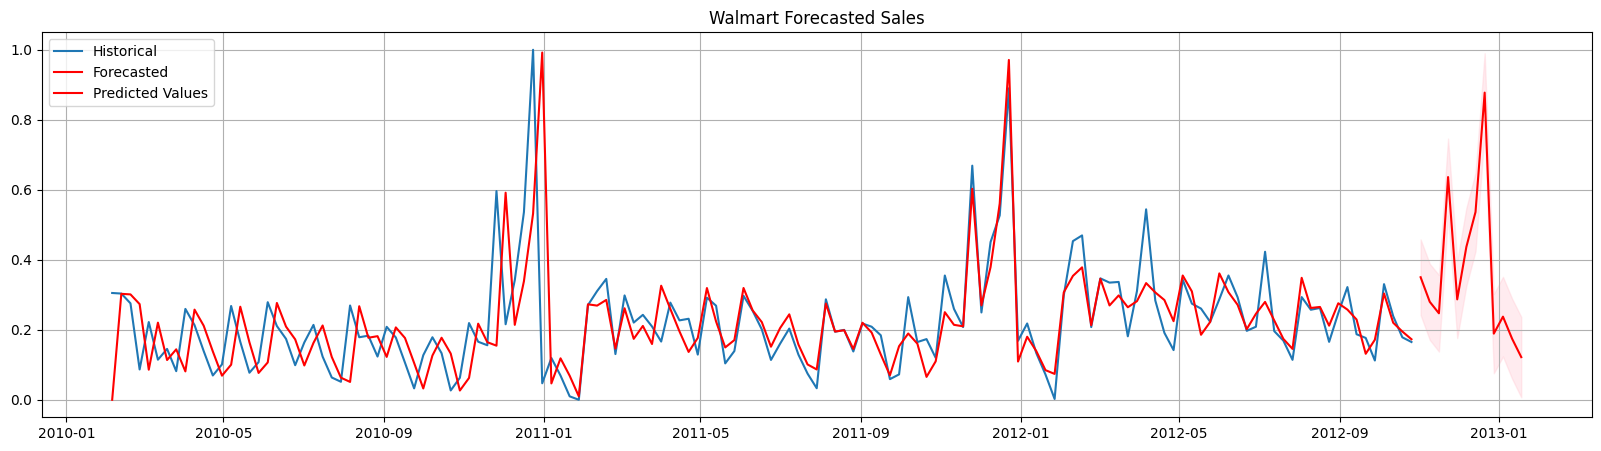

In [50]:
# plot

plt.figure(figsize=(20,5))
plt.plot(df['Weekly_Sales'], label = 'Historical')
plt.plot(forecast_mean.index , forecast_mean,label = 'Forecasted', color = 'red')
plt.plot(fitted_values.index, fitted_values, label = 'Predicted Values', color = 'red')
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:,0],
    confidence_intervals.iloc[:,1],
    color = 'pink',
    alpha = 0.3
)

plt.title('Walmart Forecasted Sales')
plt.legend()
plt.grid()
plt.show()